# Code for making predictions with and without news features

## Libraries/Data required

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Helper functions
from helper_functions import create_lag_df
from helper_functions import plot_ConfusionMatrix

data_dir = "data/" # Define data path

/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nop

In [2]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
df['district'] = df['district'].str.replace("Center", "").str.replace("South", "").str.replace("North", "").str.replace("East", "").str.replace("West", "").str.strip()
df.set_index(["date", "district"], inplace=True) # Set index
numeric_columns = df.select_dtypes(include=['number'])
df = df.groupby(["date", "district"])[numeric_columns.columns].mean().reset_index()
df.set_index(["date", "district"], inplace=True) # Set index
df

district_code      centx     centy    year  month  ipc  \
date       district                                                            
2007-01-01 Abiemnhom          136.0  29.130190  9.550939  2007.0    1.0  NaN   
           Akobo              114.0  32.853080  7.799214  2007.0    1.0  NaN   
           Anzara              86.0  28.205980  5.309739  2007.0    1.0  NaN   
           Aweil              120.6  27.139798  8.918846  2007.0    1.0  NaN   
           Awerial             99.0  31.229460  6.150162  2007.0    1.0  NaN   
...                             ...        ...       ...     ...    ...  ...   
2020-02-01 Wau                103.0  27.298230  7.284772  2020.0    2.0  3.0   
           Wulu               105.0  29.208890  6.200243  2020.0    2.0  2.0   
           Yambio              82.0  28.547290  5.124909  2020.0    2.0  3.0   
           Yei                 81.0  30.344540  4.252148  2020.0    2.0  3.0   
           Yirol              104.0  30.644715  6.594219  2020.0    2.0  3.5   

                       ha  ndvi_mean  ndvi_anom  rain_mean  ...   et_mean  \
date       district                                         ...             
2007-01-01 Abiemnhom  NaN   0.316412  100.55130   0.025810  ...  0.597288   
           Akobo      NaN   0.361317  114.89340   0.205147  ...  1.113290   
           Anzara     NaN   0.414913   94.84704   0.597445  ...  1.454028   
           Aweil      NaN   0.316901  101.51741   0.026128  ...  1.247115   
           Awerial    NaN   0.389172  106.39390   0.255114  ...  0.510219   
...                   ...        ...        ...        ...  ...       ...   
2020-02-01 Wau        0.0   0.370605  101.23200   0.597954  ...  0.122069   
           Wulu       0.0   0.374735  108.55950   0.665396  ...  0.125452   
           Yambio     0.0   0.468085  103.87600   1.465522  ...  2.018053   
           Yei        0.0   0.452878  105.17720   2.409410  ...  7.450696   
           Yirol      0.0   0.364909  118.40925   0.531674  ...  0.370820   

                       et_anom  count_violence  sum_fatalities  \
date       district                                              
2007-01-01 Abiemnhom  0.162672             0.0             0.0   
           Akobo      0.265087             0.0             0.0   
           Anzara    -1.051144             0.0             0.0   
           Aweil      0.455079             0.0             0.0   
           Awerial   -0.027814             0.0             0.0   
...                        ...             ...             ...   
2020-02-01 Wau       -0.105357             0.0             0.0   
           Wulu      -0.243994             1.0             1.0   
           Yambio     0.066441             0.0             0.0   
           Yei        4.531602             0.0             0.0   
           Yirol     -0.021709             1.5             9.5   

                      food_price_idx       area  cropland_pct         pop  \
date       district                                                         
2007-01-01 Abiemnhom        0.600941   2408.233      1.742261   18973.210   
           Akobo            0.616429   9027.626     10.046920  147537.900   
           Anzara           0.567126   6541.319     18.819290   71208.900   
           Aweil            0.600856   6197.357     14.740720  162124.700   
           Awerial          0.852021   4565.223      4.577788   51774.270   
...                              ...        ...           ...         ...   
2020-02-01 Wau             91.656480  19293.260      0.332958  177331.200   
           Wulu            83.059000  11894.780      0.032678   45158.500   
           Yambio          78.067220   8896.165     19.126490  197278.900   
           Yei             91.476050   6713.251     16.303490  288875.400   
           Yirol          101.200350   5239.805      1.472606   92836.865   

                      ruggedness_mean  pasture_pct  
date       district                                 
2007-01-01 A

## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

In [3]:
# ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
# ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
# ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

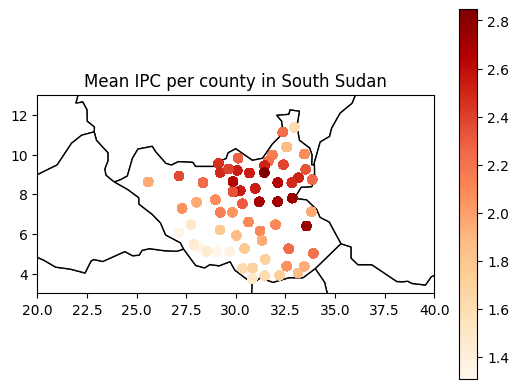

In [4]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [5]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns, len(df.columns) # View the newly created columns

(Index(['district_code', 'centx', 'centy', 'year', 'month', 'ipc', 'ha',
        'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
        'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
        'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct',
        'count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
        'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
       dtype='object'),
 27)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10112 entries, (Timestamp('2007-01-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district_code         10112 non-null  float64
 1   centx                 10112 non-null  float64
 2   centy                 10112 non-null  float64
 3   year                  10112 non-null  float64
 4   month                 10112 non-null  float64
 5   ipc                   2496 non-null   float64
 6   ha                    1792 non-null   float64
 7   ndvi_mean             10112 non-null  float64
 8   ndvi_anom             10112 non-null  float64
 9   rain_mean             10112 non-null  float64
 10  rain_anom             10112 non-null  float64
 11  et_mean               10112 non-null  float64
 12  et_anom               10112 non-null  float64
 13  count_violence        10112 non-null 

In [7]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     243.5
Date:                Sat, 30 Sep 2023   Prob (F-statistic):          2.49e-175
Time:                        21:45:28   Log-Likelihood:                -194.80
No. Observations:                 791   AIC:                             403.6
Df Residuals:                     784   BIC:                             436.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.1684 

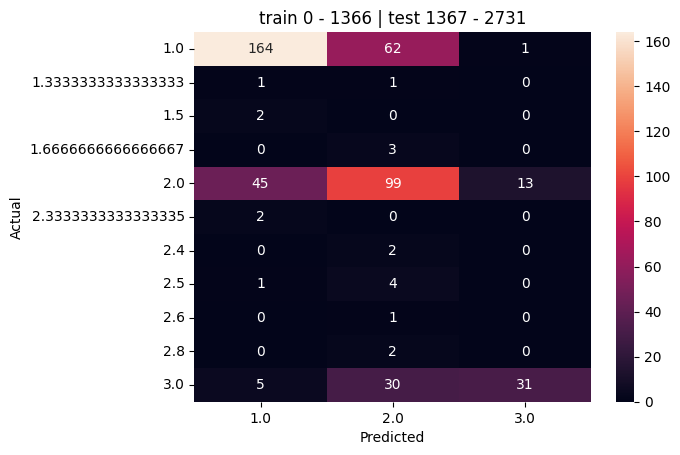

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     505.5
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:45:29   Log-Likelihood:                -1138.9
No. Observations:                2156   AIC:                             2292.
Df Residuals:                    2149   BIC:                             2332.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1573 

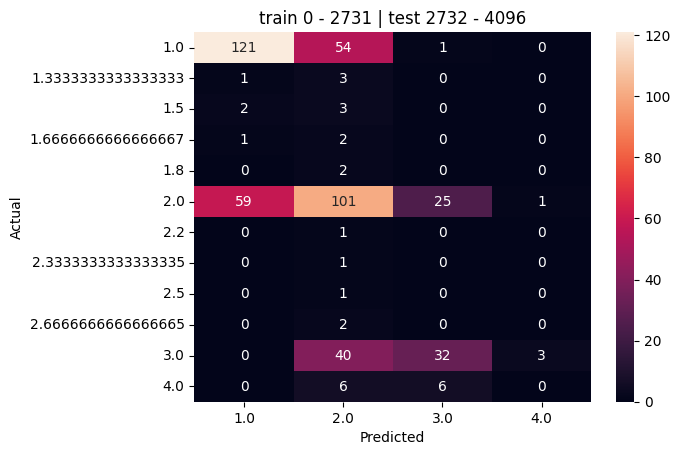

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     877.3
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:45:29   Log-Likelihood:                -2051.5
No. Observations:                3521   AIC:                             4117.
Df Residuals:                    3514   BIC:                             4160.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5064 

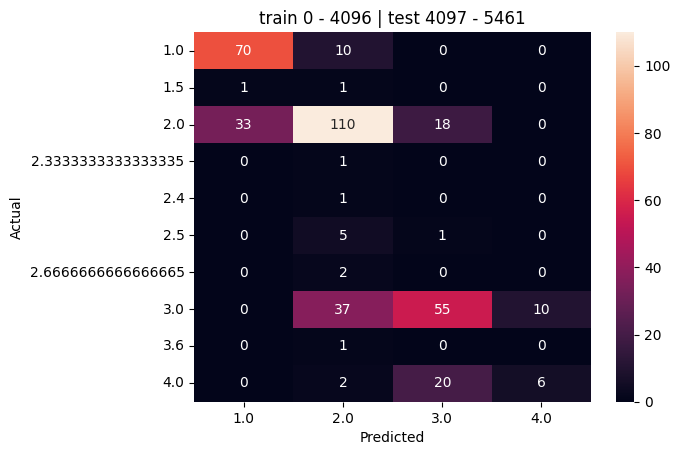

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     1741.
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:45:29   Log-Likelihood:                -2814.5
No. Observations:                4886   AIC:                             5643.
Df Residuals:                    4879   BIC:                             5689.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4405 

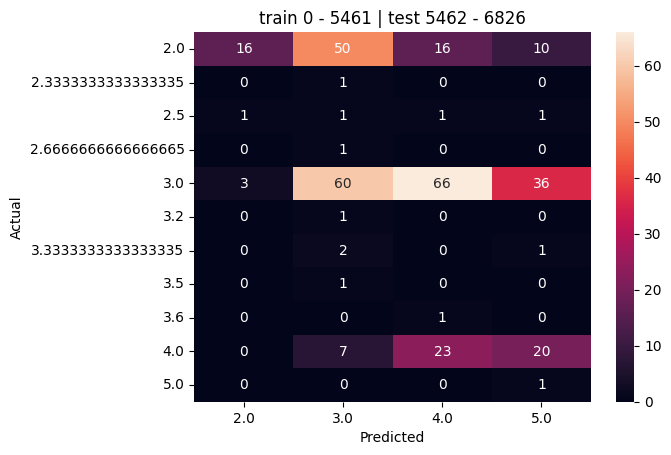

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     2793.
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:45:30   Log-Likelihood:                -3789.1
No. Observations:                6251   AIC:                             7592.
Df Residuals:                    6244   BIC:                             7639.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4397 

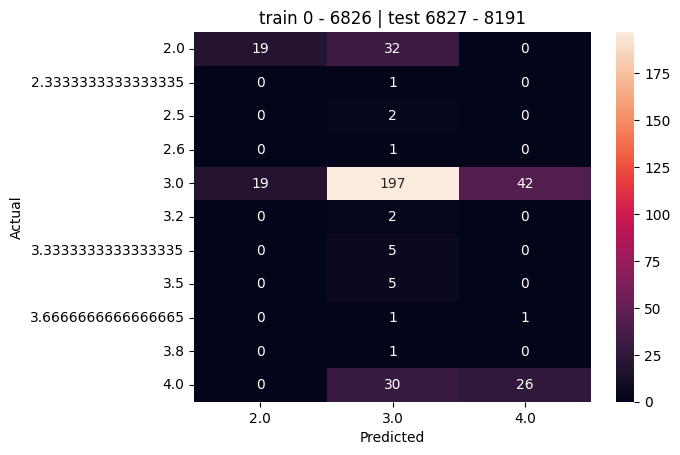

Mean MAE: 0.54
Mean R2: 0.65


<Figure size 640x480 with 0 Axes>

In [8]:
X = df.iloc[:, -6:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [9]:
news_df = pd.read_csv(data_dir + "df_news_districted.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_df = news_df.drop(columns=['Unnamed: 0'])
news_df = news_df.rename(columns = {'districts': 'district'})
# news_df = news_df.rename(columns={"location_article": "district"})

In [10]:
news_df

,title,date,paragraphs,publisher,hunger,refugees,humanitarian,conflict,district
0,South Sudan: A Former Child Soldier Fights to ...,2021-02-01,"Sara, who was abducted at age 12, spent two ye...",Thomson Reuters Foundation (London),False,False,False,False,Bor
1,South Sudan: A Former Child Soldier Fights to ...,2021-02-01,"Sara, who was abducted at age 12, spent two ye...",Thomson Reuters Foundation (London),False,False,False,False,Jur River
2,South Sudan: A Former Child Soldier Fights to ...,2021-02-01,"Sara, who was abducted at age 12, spent two ye...",Thomson Reuters Foundation (London),False,False,False,False,Aweil
3,South Sudan: A Former Child Soldier Fights to ...,2021-02-01,"Sara, who was abducted at age 12, spent two ye...",Thomson Reuters Foundation (London),False,False,False,False,Morobo
4,South Sudan: A Former Child Soldier Fights to ...,2021-02-01,"Sara, who was abducted at age 12, spent two ye...",Thomson Reuters Foundation (London),False,False,False,False,Magwi
...,...,...,...,...,...,...,...,...,...
361099,South Sudan: African Union Postpones Abyei Rec...,2015-06-01,The African Union on Wednesday (June 24) postp...,Government of Ethiopia (Addis Ababa),False,False,False,False,Fashoda
361100,South Sudan: African Union Postpones Abyei Rec...,2015-06-01,The African Union on Wednesday (June 24) postp...,Government of Ethiopia (Addis Ababa),False,False,False,False,Manyo
361101,South Sudan: African Union Postpones Abyei Rec...,2015-06-01,The African Union on Wednesday (June 24) postp...,Government of Ethiopia (Addis Ababa),False,False,False,False,Melut
361102,South Sudan: African Union Postpones Abyei Rec...,2015-06-01,The African Union on Wednesday (June 24) postp...,Government of Ethiopia (Addis Ababa),False,False,False,False,Renk


In [11]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date", 'district'])[column].mean()
        col = col.fillna(0)
        col = col.rolling(5).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

In [12]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])

# news_features.plot();
news_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9156 entries, (Timestamp('2011-05-01 00:00:00'), 'Abiemnhom') to (Timestamp('2023-04-01 00:00:00'), 'Mayom')
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hunger        9149 non-null   float64
 1   refugees      9149 non-null   float64
 2   conflict      9149 non-null   float64
 3   humanitarian  9149 non-null   float64
dtypes: float64(4)
memory usage: 314.7+ KB


In [13]:
news_features

hunger  refugees  conflict  humanitarian
date       district                                           
2011-05-01 Abiemnhom     NaN       NaN       NaN           NaN
           Akobo         NaN       NaN       NaN           NaN
           Anzara        NaN       NaN       NaN           NaN
           Aweil         NaN       NaN       NaN           NaN
           Awerial       NaN       NaN       NaN           NaN
...                      ...       ...       ...           ...
2023-03-01 Yirol         0.0       0.0       0.0           0.0
2023-04-01 Juba          0.0       0.0       0.0           0.0
           Koch          0.0       0.0       0.0           0.0
           Leer          0.0       0.0       0.0           0.0
           Mayom         0.0       0.0       0.0           0.0

[9156 rows x 4 columns]

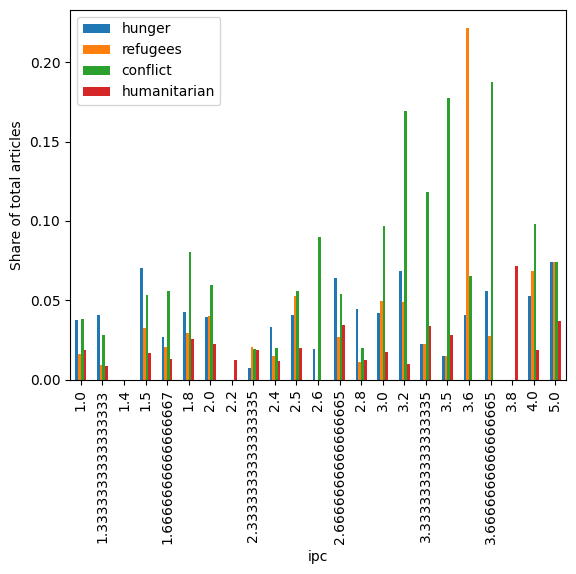

In [14]:
# Get the mean share of articles per ipc for the different topics
combined = (
    pd.DataFrame(y['ipc'])
    .join(news_df.groupby(["date", "district"])["hunger"].mean())
    .join(news_df.groupby(["date", "district"])["refugees"].mean())
    .join(news_df.groupby(["date", "district"])["conflict"].mean())
    .join(news_df.groupby(["date", "district"])["humanitarian"].mean())
)


# Plot the mean share of articles per ipc value for the different topics
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
    kind="bar", ylabel="Share of total articles"
);

## Predicting using news features

In [15]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8192 entries, (Timestamp('2009-07-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district_code         8192 non-null   float64
 1   centx                 8192 non-null   float64
 2   centy                 8192 non-null   float64
 3   year                  8192 non-null   float64
 4   month                 8192 non-null   float64
 5   ipc                   2496 non-null   float64
 6   ha                    1792 non-null   float64
 7   ndvi_mean             8192 non-null   float64
 8   ndvi_anom             8192 non-null   float64
 9   rain_mean             8192 non-null   float64
 10  rain_anom             8192 non-null   float64
 11  et_mean               8192 non-null   float64
 12  et_anom               8192 non-null   float64
 13  count_violence        8192 non-null   

In [17]:
df['hunger'] = df['hunger'].fillna(0)
df['refugees'] = df['refugees'].fillna(0)
df['conflict'] = df['conflict'].fillna(0)
df['humanitarian'] = df['humanitarian'].fillna(0)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8192 entries, (Timestamp('2009-07-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district_code         8192 non-null   float64
 1   centx                 8192 non-null   float64
 2   centy                 8192 non-null   float64
 3   year                  8192 non-null   float64
 4   month                 8192 non-null   float64
 5   ipc                   2496 non-null   float64
 6   ha                    1792 non-null   float64
 7   ndvi_mean             8192 non-null   float64
 8   ndvi_anom             8192 non-null   float64
 9   rain_mean             8192 non-null   float64
 10  rain_anom             8192 non-null   float64
 11  et_mean               8192 non-null   float64
 12  et_anom               8192 non-null   float64
 13  count_violence        8192 non-null   

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     243.5
Date:                Sat, 30 Sep 2023   Prob (F-statistic):          2.49e-175
Time:                        21:45:38   Log-Likelihood:                -194.80
No. Observations:                 791   AIC:                             403.6
Df Residuals:                     784   BIC:                             436.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.1684 

/home/egor/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


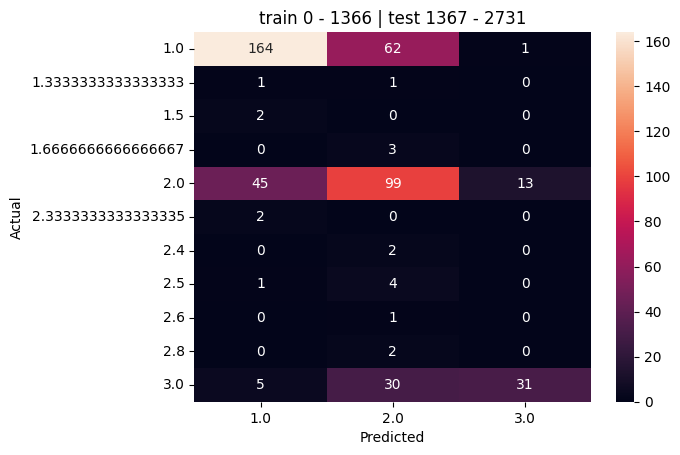

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     306.5
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:45:39   Log-Likelihood:                -1131.0
No. Observations:                2156   AIC:                             2284.
Df Residuals:                    2145   BIC:                             2346.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1689 

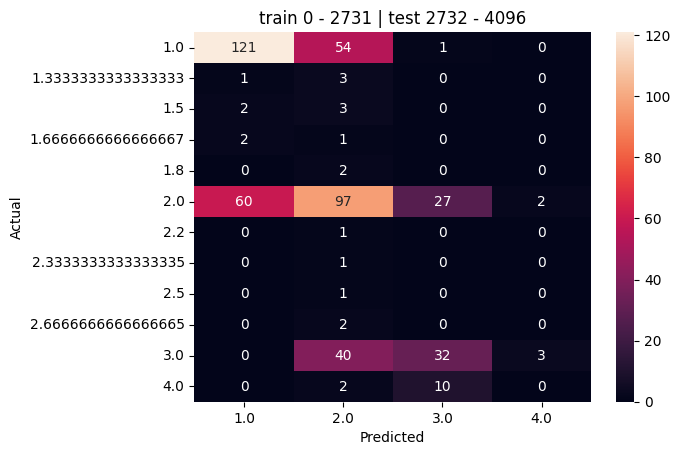

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     554.0
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:45:39   Log-Likelihood:                -1995.7
No. Observations:                3521   AIC:                             4013.
Df Residuals:                    3510   BIC:                             4081.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1461 

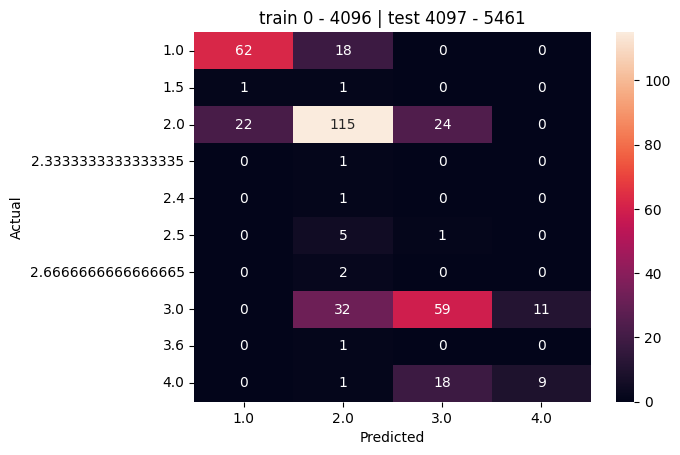

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     1066.
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:45:40   Log-Likelihood:                -2779.8
No. Observations:                4886   AIC:                             5582.
Df Residuals:                    4875   BIC:                             5653.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2187 

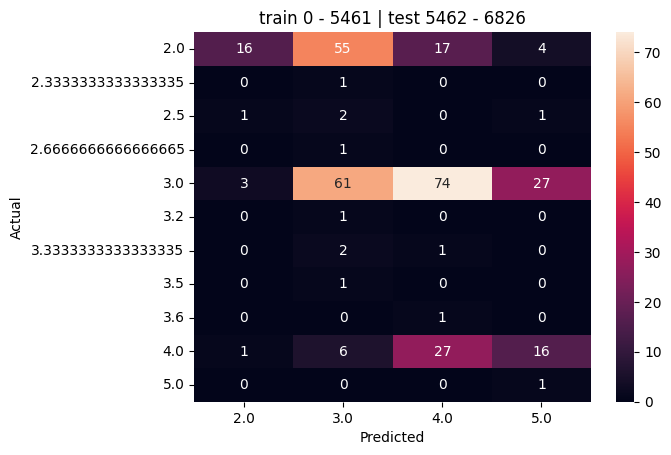

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     1731.
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:45:40   Log-Likelihood:                -3714.0
No. Observations:                6251   AIC:                             7450.
Df Residuals:                    6240   BIC:                             7524.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1313 

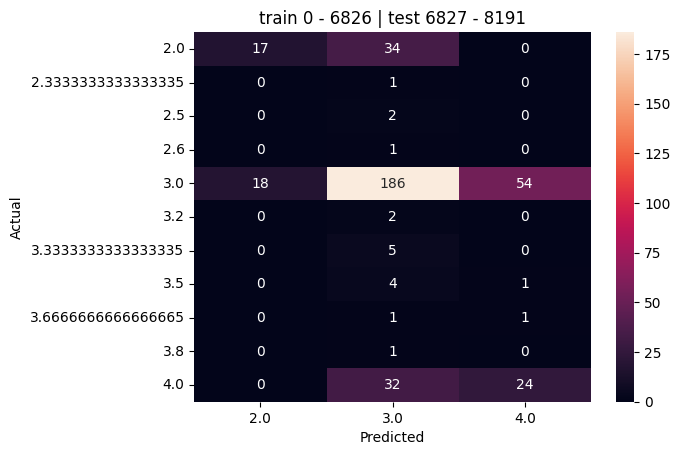

Mean MAE: 0.53
Mean R2: 0.65


<Figure size 640x480 with 0 Axes>

In [19]:
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model


# df_prep = df.copy().iloc[:, [7] + list(range(-10, 0))].dropna()


X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data

    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

We see that the R2 has risen somewhat compared to the baseline.

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [20]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

Optimization terminated successfully.
         Current function value: 0.027695
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                  791
Model:                          Logit   Df Residuals:                      787
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.6135
Time:                        21:45:41   Log-Likelihood:                -21.907
converged:                       True   LL-Null:                       -56.676
Covariance Type:            nonrobust   LLR p-value:                 5.358e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.8979      2.171     -5.941      0.000     -17.153      -8.643
ipc_lag_1      4.9117      1

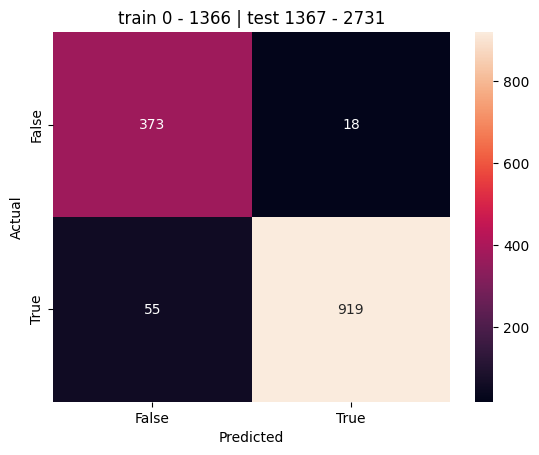

Optimization terminated successfully.
         Current function value: 0.199472
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 2156
Model:                          Logit   Df Residuals:                     2152
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.4008
Time:                        21:45:41   Log-Likelihood:                -430.06
converged:                       True   LL-Null:                       -717.78
Covariance Type:            nonrobust   LLR p-value:                2.137e-124
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8868      0.375    -21.013      0.000      -8.622      -7.151
ipc_lag_1      3.0028      0.

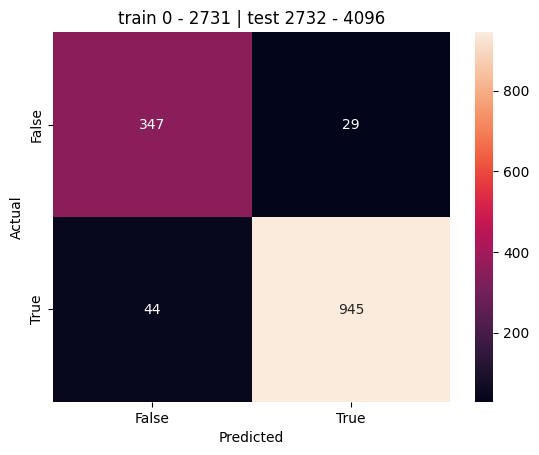

Optimization terminated successfully.
         Current function value: 0.232078
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 3521
Model:                          Logit   Df Residuals:                     3517
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.3983
Time:                        21:45:41   Log-Likelihood:                -817.15
converged:                       True   LL-Null:                       -1358.2
Covariance Type:            nonrobust   LLR p-value:                2.906e-234
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.5990      0.277    -27.447      0.000      -8.142      -7.056
ipc_lag_1      2.9430      0.

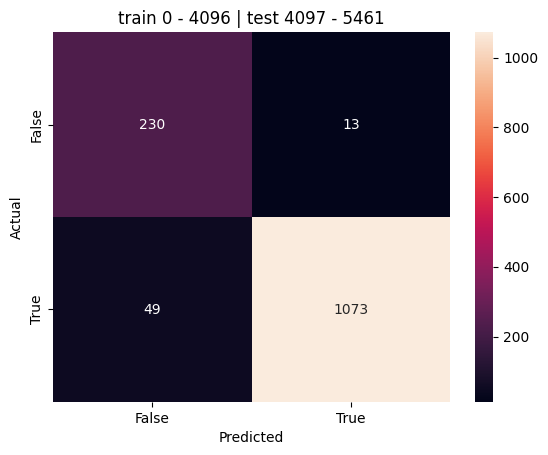

Optimization terminated successfully.
         Current function value: 0.260141
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 4886
Model:                          Logit   Df Residuals:                     4882
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.4703
Time:                        21:45:42   Log-Likelihood:                -1271.0
converged:                       True   LL-Null:                       -2399.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8850      0.228    -34.573      0.000      -8.332      -7.438
ipc_lag_1      3.0244      0.

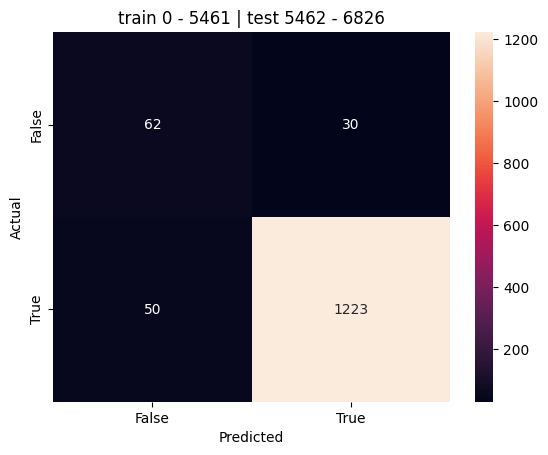

Optimization terminated successfully.
         Current function value: 0.292594
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    ipc   No. Observations:                 6251
Model:                          Logit   Df Residuals:                     6247
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 Sep 2023   Pseudo R-squ.:                  0.5272
Time:                        21:45:42   Log-Likelihood:                -1829.0
converged:                       True   LL-Null:                       -3868.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.0920      0.196    -41.201      0.000      -8.477      -7.707
ipc_lag_1      2.7643      0.

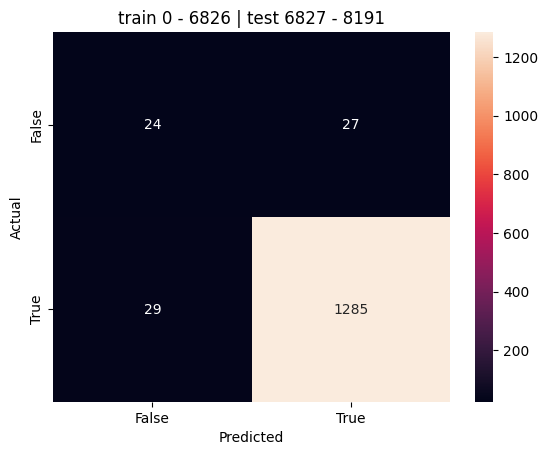

Mean Acc: 0.95


<Figure size 640x480 with 0 Axes>

In [21]:
X = df.iloc[:, -10:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
acc_values = list() # Initinalize empty lists to score accuracy scores

for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)
    
    cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
    model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test[cols]) # Run model on test data

    # Convert prediction and validation to boolean
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)

    # Drop all rows from prediction and validation where validation is null
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)

    acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc